In [2]:
#imports
import numpy as np

### Define Object Classes

In [3]:
class Station():

    def __init__(self,nodeId,name, sttype, mhtime):
        self.nodeId = int(nodeId)
        self.name = name
        self.sttype = sttype
        self.mhtime = mhtime
    
    def __str__(self):
        return f"Station#{self.nodeId} - {self.name} - {self.sttype}"
    
    def getType(self):
        return self.sttype
    
    def getNode(self):
        '''
        returns its node
        '''
        return self.nodeId

In [4]:
class TransportOrder():
    
    def __init__(self,index,source, dest, ept, ldt, cap,taskType='t'):
        self.id=index
        self.source = source
        self.dest = dest
        self.ept = ept
        self.ldt = ldt
        self.cap=cap
        self.taskType = taskType
        self.idf=0
        
    def __str__(self):
        return f"TO#{self.id}: From {self.source} to {self.dest}, window: {self.ept} - {self.ldt}, capability: {self.cap}"
    
    def __repr__(self):
        return f"TO#{self.id}: From {self.source} to {self.dest}, window: {self.ept} - {self.ldt}, capability: {self.cap}"
        

In [5]:
class Task(TransportOrder):

    def __init__(self,name, processingTime,source, dest, ept, ldt, taskType, cap=0,index=999):
        self.name = name
        self.processingTime = processingTime
        super().__init__(index,source, dest, ept, ldt, cap,taskType)

    def __str__(self):
        return f"Task {self.name}, type:{self.taskType} - From {self.source} to {self.dest} window:{self.ept} - {self.ldt}, Minimum Processing:{self.processingTime} secs"
     
    def __repr__(self):
            return f"Task {self.name}, type:{self.taskType} - From {self.source} to {self.dest} window:{self.ept} - {self.ldt}, Minimum Processing:{self.processingTime} secs"

In [6]:
class AGV():
    def __init__(self, agvidf, startNode, caps, speed, charge = 100, dischargeRate = 0.5, 
                 chargingRate =1, travelCost =1):
        self.chargingStations=list() #could be in layout class
        self.agvidf = agvidf #agv id
        self.startNode = startNode #initial node
        self.caps = caps #capability
        self.speed = speed # speed in m/s
        self.charge = charge # charge %
        self.dischargeRate = dischargeRate # % per second
        self.chargingRate = chargingRate # % per second
        self.taskList = list() # list of tasks
        self.release=(0, startNode) #(time, location)
        self.travelCost = travelCost # weighted travel cost
        self.LOWER_THRESHOLD = 30 # lower threshold of charging
        self.UPPER_THRESHOLD =60 # upper threshold of charging
        self.state = 'N'
        self.lateness = 0 #calculate lateness of jobs
        self.initialSeqFile = ""
        
    def __str__(self):
        return f"AGV#{self.agvidf}, capability:{self.caps}"
    
    def addTask(self,task):
        extraCharge=0
        if self.state =='C':
            if self.release[0] < task.ept:
                extraCharge = (task.ept - self.release[0])*self.chargingRate
                self.charge = min(100,self.charge+extraCharge)
                self.state = 'N'
            else:
                task.ept = self.release[0]
                self.state = 'N'
        self.updateReleaseInformation(task,extraCharge)
        
    def getCurrentReleaseNode(self):
        return self.release[1]
    def getCurrentReleaseTime(self):
        return self.release[0]
    def setCurrentReleaseNode(self,releaseNode):
        self.release=(self.release[0],releaseNode)
        
    def updateReleaseInformation(self, task, extraCharge=0):
        print(f"AGV{self.agvidf} is at {self.release}, charge: {self.charge-extraCharge}")
        drivingDist = getDistanceFromNode(self.getCurrentReleaseNode(),task.source)+(getDistanceFromNode(task.source,task.dest))
        
        drivingTime = drivingDist/self.speed 
        
        mhtime = getStationMHT(task.source)+getStationMHT(task.dest) # get material handling time for loading and unloading
        # release time to be set to the max of ept or current release time
        self.release = ((max(task.ept,self.getCurrentReleaseTime())+(getDistanceFromNode(self.getCurrentReleaseNode(),task.source))/self.speed+
                        (getDistanceFromNode(task.source,task.dest))/self.speed)+mhtime
            ,self.release[1])
        
        self.setCurrentReleaseNode(task.dest) #agv would be at destination of the task after finishing it...
        
        self.charge = self.charge - (drivingTime * self.dischargeRate)
        print(f"{self} after finishing task:{task}, Charge:{self.charge}, release: {self.release}")
        
        #calculate lateness if any
        self.lateness+= max(0,self.getCurrentReleaseTime()-task.ldt)
        print(f'Lateness of order:{task.id},ldt:{task.ldt}, lateness:{max(0,self.getCurrentReleaseTime()-task.ldt )}, total lateness of this agv:{self.lateness}')
        
        self.taskList.append(task)
        if self.charge <=self.LOWER_THRESHOLD + 0.2*self.LOWER_THRESHOLD:
            self.createCriticalCharge()
            
    def createCriticalCharge(self):
        print(f"critical charge called at charge: {self.charge}")
        self.state ='C'
        dists = [getDistanceFromNode(self.getCurrentReleaseNode(),station.getNode()) for station in chargingStations]
        optIndex = dists.index(min(dists))
        nearestChargeNode = chargingStations[optIndex].getNode()
        
        #drive to nearest charge location and start charging for minimum required amount
        drivingDist = getDistanceFromNode(self.getCurrentReleaseNode(), nearestChargeNode)
        
        drivingTime = drivingDist/self.speed
            
        self.charge = self.charge - (drivingTime * self.dischargeRate)
        
        chargeRequired = self.LOWER_THRESHOLD - self.charge
        timeRequiredToCharge = chargeRequired / self.chargingRate
        
        task = Task("Charge", timeRequiredToCharge , self.getCurrentReleaseNode(), nearestChargeNode, 0, 0, 'C', cap=0,index=99)
        self.taskList.append(task)
        print(f"critical charge started at charge: {self.charge}")
        self.release = (self.release[0]+drivingTime+timeRequiredToCharge,self.release[1]) # point at which AGV is 30% charged
        self.setCurrentReleaseNode(nearestChargeNode) # location at which AGV is 30% charged
        self.charge = self.LOWER_THRESHOLD
        print(f"critical charge finished at: {self.release}")
    
    def getLatenessScore(self,task):
        
        lhCharge =self.charge
        lhept = max(task.ept,self.getCurrentReleaseTime())
        if self.state =='C':
            if self.release[0] < task.ept:
                extraCharge = (task.ept - self.release[0])*self.chargingRate
                lhCharge = min(100,self.charge+extraCharge)

            else:
                lhept = self.release[0]
                
        late = lhept + ((getDistanceFromNode(self.getCurrentReleaseNode(), task.source)+ \
                                                getDistanceFromNode(task.source, task.dest))/(self.speed)-task.ldt)
        
        return penalty(late)
    
    
    def getDistScore(self, task):
        return getDistanceFromNode(self.getCurrentReleaseNode(), task.source)*self.travelCost

### Penalty function for lateness

In [7]:
def penalty(x,a=1.5,b=1.1,c=-1.5):
    '''
    https://www.desmos.com/calculator/3fisjexbvp
    '''
    x=x/60   # we divide by 60 to convert time into minutes
    return max(0,(a*(pow(b,x))+c))

## Read Excel Files

In [8]:
from csv import reader

def readDistanceMatrix(distMatrixFile):
    dm = reader(open(distMatrixFile))
    global distMat #used to create global variables from a non-global scope i.e inside a function.
    distMat = list(dm)
    distMat[0][0]=0
    
    
    #print(distMat[1][4])

def getDistanceFromNode(source,dest):
    '''
    returns the distance (in m) between 2 nodes
    '''
    return float(distMat[source][dest])

#read distance matrix
readDistanceMatrix('outputDM.csv')

## Create main

In [9]:
from csv import reader
from pandas import read_excel


unscheduledTOs = list()
scheduledTOs = dict()
chargingStations = list()
stations = list()
taskList={}

#scheduledTOs["some"]="something"
agvs=list()

def getStationMHT(intId): #could be in layout
    intId = int(intId)
    st = [x for x in stations if x.nodeId == intId]
    
    if st:
        return st[0].mhtime
    

def createAGVs(agvfile):
    df =read_excel(agvfile)
    for index,row in df.iterrows():
        agv = AGV(agvidf=row['agvidf'], startNode=row['startNode'],caps= row['capability'], speed=row['speed'],
                 dischargeRate= row['dischargeRate'], chargingRate = row['chargingRate'],travelCost = row['travelCost'])
        agvs.append(agv)
        print(f'{agv} created')
    

def createRequests(demandfile):
    df =read_excel(demandfile)
    for index,row in df.iterrows():
        transportOrder = TransportOrder(row['Id'], row['source'], row['target'], row['ept'], row['ldt'], row['capability'])
        unscheduledTOs.append(transportOrder)
        print(f'{transportOrder} created')

def createStations(stationFile):
        df = read_excel(stationFile)
        for index, row in df.iterrows():
                station = Station(row['id'], row['pointidf'], row['type'], row['mhtime'])
                stations.append(station)
                if station.getType() == 'C':
                        chargingStations.append(station)
                print(f"{station} created")


def createSequenceTO():
        unscheduledTOs.sort(key = lambda x: x.ldt) # sort based on delivery time
        print("Unscheduled List Ordered based on ldt")
        numAGVs = len(agvs)
       
        for to in unscheduledTOs:
                agv_count=[agv for agv in agvs if to.cap in agv.caps]
                for c in agv_count:
                    print(f"TO#{to.id} can be done by AGV{c.agvidf} with current charge : {c.charge}%")
                

                if len(agv_count)==1:
                        agv_count[0].addTask(to)
                if len(agv_count)>1:
                        scores = []
                        
                        for agv in agv_count:
                            score = agv.getDistScore(to)+agv.getLatenessScore(to)
                            print(f"Computed score for AGV#{agv.agvidf}:{score}")
                            scores.append(score)
                            
                        optIndex = scores.index(min(scores))
                        agv_count[optIndex].addTask(to)
                
        
                
def writeSequenceToFile():
    '''
    writes the sequence to file after processing
    '''
    #summarize sequence and add unique identifiers to tasks
    for agv in agvs:
        for t in agv.taskList:
            t.idf = agv.taskList.index(t)
            
    for agv in agvs:
        taskList[agv.agvidf]=[]
        import csv
        agv.initialSeqFile = f"agv{agv.agvidf}.csv"
        with open(f"agv{agv.agvidf}.csv",'w') as f:
            f.write('Request_Number,SRC,EPT,DEST,LDT,MHT\n')
            f.write(f"{98},{agv.startNode},{0},{agv.taskList[0].source},{0},{getStationMHT(agv.startNode)}\n")
            taskDict = {}
            taskDict['Request_Number']=98
            taskDict['SRC']=agv.startNode
            taskDict['EPT']=0
            taskDict['DEST']=agv.taskList[0].source
            taskDict['LDT']=0
            taskDict['MHT']=getStationMHT(agv.startNode)
            taskDict['UDIST']=getDistanceFromNode(taskDict['SRC'],taskDict['DEST'])
            taskDict['LDIST']=0.0
            taskList[agv.agvidf].append(taskDict)
            for i,task in enumerate(agv.taskList):
                f.write(f"{task.id},{task.source},{task.ept},{task.dest},{task.ldt},{getStationMHT(task.source)}\n")
                taskDict = {}
                taskDict['Request_Number']=task.id
                taskDict['IDF']=task.idf
                taskDict['SRC']=task.source
                taskDict['EPT']=task.ept
                taskDict['DEST']=task.dest
                taskDict['LDT']=task.ldt
                taskDict['MHT']=getStationMHT(task.source)
                if task.taskType=='C':
                    taskDict['UDIST']=getDistanceFromNode(taskDict['SRC'],taskDict['DEST'])
                    taskDict['LDIST']=0.0
                else:
                    taskDict['UDIST']=0.0
                    taskDict['LDIST']=getDistanceFromNode(taskDict['SRC'],taskDict['DEST'])
                taskList[agv.agvidf].append(taskDict)
                if i<len(agv.taskList)-1 and agv.taskList[i+1].taskType !='C':
                    f.write(f"{100},{task.dest},{0},{agv.taskList[i+1].source},{0},{getStationMHT(task.dest)}\n")
                    taskDict = {}
                    taskDict['Request_Number']=100
                    taskDict['SRC']=task.dest
                    taskDict['EPT']=0
                    taskDict['DEST']=agv.taskList[i+1].source
                    taskDict['LDT']=0
                    taskDict['MHT']=getStationMHT(task.dest)
                    taskDict['UDIST']=getDistanceFromNode(taskDict['SRC'],taskDict['DEST'])
                    taskDict['LDIST']=0.0
                    taskList[agv.agvidf].append(taskDict)

    
#Gurobi implementation
from gurobipy import *
import gurobipy as grb
import pandas as pd
import numpy as np
import csv

# initialize LP model
def solveLP(agv):

    #Reading distance matrix
    filename2=str("outputDM.csv")
    dij = list(csv.reader(open(filename2)))
    dij[0][0]=0
    for i in range(len(dij)):
        for j in range(len(dij)):
            dij[i][j]=float(dij[i][j])
    #Charging Nodes
    C=[x.nodeId for x in chargingStations]
    
    #Speed of AGV
    sp=agv.speed #mps
    #Battery discharge rate
    dcr=agv.dischargeRate
    #Battery charge rate
    cr=agv.chargingRate

    #Reading requests
    req = pd.read_csv(agv.initialSeqFile)
    SRC = req['SRC'].tolist()
    EPT = req['EPT'].tolist()
    DEST = req['DEST'].tolist()
    LDT = req['LDT'].tolist()
    MHT = req['MHT'].tolist()
    REQ = req['Request_Number'].tolist()

    #GUROBI
    m = grb.Model('Scheduling')

    #minimization model
    m.modelSense = GRB.MINIMIZE


    #decision variables
    #variable for lateness of request r
    Z = {(r):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"Z_{r}") for r in range(len(req))} # 0 becuase we do not consider earliness

    #variable to represent the time instance at which AGV reaches 'source' of a request r
    S = {(r):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"S_{r}") for r in range(len(req))}

    #variable to represent the time instance at which AGV reaches 'destination' of a request r
    D = {(r):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"D_{r}") for r in range(len(req))}

    #variable to represent the battery status at the beginning of request r
    B = {(r):m.addVar(vtype = GRB.CONTINUOUS, lb = 30.0, ub=100.0, name = f"B_{r}") for r in range(len(req))} #changes lb = 0 from 30.0
    
    #critical battery level
#     c = m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, ub = 100.0, name ="battery bounds")

    #battery can reach 0% only at charging stations
    for r in range(len(req)):
        if SRC[r] in C:
            B[r].lb=0.0

    #objective function
    #Objective 1 - To minimize lateness
    obj_lateness = grb.quicksum(Z[r] for r in range(len(req)))

    # #Objective 2 - To maximize charging duration and minimize parking duration at source and destination nodes
    obj_charging = grb.quicksum(0 if SRC[r] in C else 1*(S[r+1]-S[r]) for r in range(len(req)-1))

    #Objective 3 - To minimize Unloaded Travel Time
    obj_unloaded = grb.quicksum(0 if REQ[r]<98 else 1*(D[r] - S[r]) for r in range(len(req))) # becoz that's where unloaded travel occurs

    m.setObjective(obj_lateness+obj_charging)
    #+obj_charging+obj_unloaded
    #Constraints
    
    
    
    #Constraint 1 - trip time should be less than Destination time instance
    for r in range(len(req)):
        i=SRC[r]
        j=DEST[r]
        m.addConstr(S[r]+MHT[r]+(1/sp)*dij[i][j]<=D[r],name=f"Headway_{r}")

    #Constraint 2 - Destination of request should equal source of next request
    for r in range(len(req)-1):
        m.addConstr(D[r]==S[r+1], name=f"Dest_{r}=Src{r+1}")

    #Constraint 3 - A job cannot be picked up before EPT
    for r in range(len(req)):
        m.addConstr(EPT[r]<=S[r],name=f"S_{r}>=EPT_{r}")

    #Constraint 4 - To represent lateness Z = D - LDT 
    for r in range(len(req)):
        if LDT[r]>0:
            m.addConstr(Z[r]>=D[r]+MHT[r]- LDT[r], name = f"Z_{r}>=D_{r}-LDT_{r}") # where Z[r] represents slack, when Z{r} is -ve, it will be 0 due to lower bound


    #Constraint 5 - Battery initialization at starting nodes to 100%
    m.addConstr(B[0]==100, name=f"B_0_init")

    #Constraint 6 - Battery discharging and charging
    for r in range(len(req)-1):
        i=SRC[r]
        j=SRC[r+1]
        if i in C and r >=2:
            b = m.addVar()
            m.addConstr(b==B[r]+((S[r+1]-S[r]-(1/sp)*dij[i][j])*cr)-((1/sp)*dij[i][j]*dcr), name=f"b_{r}")
            m.addGenConstrMin(B[r+1],[b,100], name=f"B_{r}") # charge cannot be greater than 100%
        else:
            m.addConstr((B[r+1]==B[r]-((1/sp)*dij[i][j]*dcr)), name=f"B_{r}")
#             m.addConstr(B[r]>=c, name = "Critical charge") #test constraint

    #Write model to disk
    m.write('model.lp')
    #optimize model
    m.optimize()
    status = m.status
    if status == GRB.Status.UNBOUNDED:
        print('The model cannot be solved because it is unbounded')
        return False
    elif status == GRB.Status.OPTIMAL:
        print('The optimal objective is %g' % m.objVal)
        print(f"Variables of s:{len(S)}")
        src = []
        node = []
        battery = []
        late = sum(Z[z].x for z,y in enumerate(range(len(Z))))
        print(f'Lateness:{late:.2f} seconds')
        tardinessLP.append(late)
        
#         print(f'Critical Charge :{c.x}%')
        for r,s in enumerate(S):
            print(f"{S[r].varName},{D[r].varName},{B[r].varName}:{S[r].x},{D[r].x},{B[r].x}")
            node.append(r)
            src.append(S[r].x)
            battery.append(B[r].x)
        
        #print values
        %matplotlib inline
        from matplotlib import pyplot as plt
        c=['blue','coral','cyan','magenta','green','red'] 
        #Colors for Loaded Travel Time, Unloaded Travel Time, Loading Time, Unloading Time, Charging Time and Waiting Time
        bY=[] #battery level - y - axis
        bX=[] #battery time - x - axis

        plt.figure(figsize=(20,10))
        for r in range(len(req)):    
            #Material Handling Time
            x1=[S[r].x,D[r].x-(1/sp)*dij[SRC[r]][DEST[r]]]
            y1=[SRC[r],SRC[r]]
            #Waiting Time at Source and Destination if the time exceeds 10 t.u.
            if x1[1]-x1[0]>10 and SRC[r] not in C:
                x1=[S[r].x,S[r].x+10]
                xw=[S[r].x+10,D[r].x-(1/sp)*dij[SRC[r]][DEST[r]]]
                plt.plot(xw, y1, c[5],marker='o',label='Waiting Time' if 'Waiting Time' 
                         not in plt.gca().get_legend_handles_labels()[1] else '')
            #Travel Time
            x2=[D[r].x-(1/sp)*dij[SRC[r]][DEST[r]],D[r].x]
            y2=[SRC[r],DEST[r]]
            if REQ[r]<98:
        #         # Original request window
        #         plt.plot([EPT[r],LDT[r]],[SRC[r]-0.5,SRC[r]-0.5],'dimgrey')
                #Loading time
                plt.plot(x1, y1, c[2],label='Loading Time' if 'Loading Time' 
                         not in plt.gca().get_legend_handles_labels()[1] else '')
                #Loaded travel time
                plt.plot(x2, y2, c[0],label='Loaded travel Time' if 'Loaded travel Time' 
                         not in plt.gca().get_legend_handles_labels()[1] else '')
            else:
                #unloaded travel time
                plt.plot(x2, y2, c[1],label='Unloaded travel Time' if 'Unloaded travel Time' 
                         not in plt.gca().get_legend_handles_labels()[1] else '')
                if SRC[r] in C:
                    #Charging time
                    plt.plot(x1, y1, c[4],label='Charging Time' if 'Charging Time' 
                             not in plt.gca().get_legend_handles_labels()[1] else '')
                else:
                    #Unloading time
                    plt.plot(x1, y1, c[3],label='Unloading Time' if 'Unloading Time' 
                             not in plt.gca().get_legend_handles_labels()[1] else '')

            #Battery status      
            bY.append(B[r].x)
            bX.append(S[r].x)
            if SRC[r] in C:
                bY.append(min(100,B[r].x+cr*(D[r].x-S[r].x-(1/sp)*dij[SRC[r]][DEST[r]])))
            else:
                bY.append(B[r].x)
            bX.append(D[r].x-(1/sp)*dij[SRC[r]][DEST[r]])  

        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 0.8))   
        plt.xlabel("Time (seconds)")
        plt.ylabel("Nodes")
        plt.yticks([i for i in range(20)],[i for i in range (20)])  
        plt.grid(True)
        #Battery status representation - Uncomment the four lines below for battery status
        plt.twinx()
        plt.ylabel("Battery status")
        plt.plot(bX,bY,label='Battery status',color='lightgrey')  
        plt.yticks([20*i for i in range(1,6)])
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85))
        plt.xlim(left=0,right=850)
        plt.show()
        
        from matplotlib import pyplot as plt
        c=['blue','coral','cyan','magenta','green','red'] 
        #Colors for Loaded Travel Time, Unloaded Travel Time, Loading Time, Unloading Time, Charging Time and Waiting Time
        bY=[] #battery level - y - axis
        bX=[] #battery time - x - axis

        plt.figure(figsize=(20,8))
        for r in range(len(req)):    
            if REQ[r]<98:
                # Original request window
                plt.plot([REQ[r],REQ[r]],[EPT[r],LDT[r]],'red',marker=0,label='Request Time Window' if 'Request Time Window' 
                         not in plt.gca().get_legend_handles_labels()[1] else '')
                # AGV carries out in
                plt.plot([REQ[r]+0.5,REQ[r]+0.5],[S[r].x, D[r].x+MHT[r]],'blue',marker=0,label='Time taken by AGV' if 'Time taken by AGV' 
                         not in plt.gca().get_legend_handles_labels()[1] else '')


        plt.legend()        
        plt.xlabel("Request Number")
        plt.ylabel("Time(Seconds)")
        plt.xticks([i for i in range(20)],[i for i in range (20)])  
        plt.grid(True)
        plt.show()
        
#         #Add data to the agv file
#         lines=[]
#         with open(f"{agv.initialSeqFile}",'r') as f:
#             for r,line in enumerate(f):
#                 if r==0:
#                     lines.append('Request_Number,SRC,EPT,DEST,LDT,MHT,Sr,Dr\n')
#                     continue
#                 elif r==len(list(f)):
#                     continue
                
#                 print(f"{line},{S[r].x},{D[r].x}\n")
#                 lines.append(f"{line},{S[r].x},{D[r].x}\n")
        
#         with open('test.csv','w') as w:
#             for l in lines:
#                 w.write(l)
        #update optimal time values in tasklist
        for r,task in enumerate(taskList[agv.agvidf]):
            task['Sr']=S[r].x
            task['Dr']=D[r].x
            task['SrMHT']=task['Sr']+task['MHT']
            task['DrSTART']=task['Dr']-(getDistanceFromNode(task['SRC'],task['DEST'])/agv.speed)
            task['WAIT']=0 if task['DrSTART']-task['SrMHT']<0.001 else task['DrSTART']-task['SrMHT']
           
        return True
            
    elif status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE:
        print('Optimization was stopped with status %d' % status)
        # do IIS
        print('The model is infeasible; computing IIS')
        m.computeIIS()
        if m.IISMinimal:
            print('IIS is minimal\n')
        else:
            print('IIS is not minimal\n')
        print('\nThe following constraint(s) cannot be satisfied:')
        for c in m.getConstrs():
            if c.IISConstr:
                print('%s' % c.constrName)
        return False

#     m.printAttr('X')

#tardinessLP=[]
#S=[0 for i in range(len(unscheduledTOs))]
#for agv in agvs:
#   solveLP(agv)
    
    
def postGurobi():
    '''
    Method to remove unnecessary charging
    '''
    changedSequence = False
    cnum=[[] for i in range(len(agvs))] # to keep track of number of charge tasks gone through for all agvs
    for a in range(len(taskList.items())):
        alist=taskList[a]
        ccount=0
        for r,task in enumerate(alist):
    #         print(r,task)
            if task['Request_Number'] == 99 and r !=len(alist)-1: # if task is of type charge and it is not the last task
                ccount+=1
                nextRequest = alist[r+1]
    #             print(nextRequest)
                dischargeTime = (task['Dr']-task['DrSTART'])+(nextRequest['Dr']-nextRequest['DrSTART']) #run only after gurobi
                discharge= dischargeTime * agvs[a].dischargeRate
                charge = nextRequest['WAIT'] * agvs[a].chargingRate
                if charge<=discharge:
                    cnum[a].append(ccount)

    #     print([a.id for a in agvs[a].taskList])
    print(cnum)

    for a,agv in enumerate(agvs):
        chargeCount=0
        toRemove=[]

        for task in agv.taskList:
            print(task)
            if task.taskType =='C':
                chargeCount+=1
                if chargeCount in cnum[a]:
                    changedSequence=True # if the sequence of any agv was changed
                    toRemove.append(task)
        
        agv.taskList = [task for task in agv.taskList if task not in toRemove]
        print("---------------------after-----------------")
        for task in agv.taskList:
            print(task)
    
    if changedSequence:
        writeSequenceToFile()
    
    return changedSequence


print("-----------------------------------KPI------------------------------------------")
#print(f"Tardiness after EDD dispatching:{tardinessGreedy :.2f} seconds")
#print(f"Total tardiness after solving via LP:{sum(tardinessLP):.2f} seconds")
# solveLP(agvs[0])

#Solve LP formulation to schedule tasks on agvs

#improve while it can be improved..
def improveLP():
    '''
    Improves LP solution by removing -ve increase in battery level
    '''
    changed = postGurobi()
    print("---------------------------changed",changed)
    while changed:
        for agv in agvs:
            solveLP(agv)
        changed = postGurobi() #
        
        
def solve():
    '''
    Solve LP
    '''
    solvable = True
    for agv in agvs:
        solvable_t = solveLP(agv)
        if not solvable_t:
            solvable=False
        
    if solvable:
        improveLP()
    return solvable
  


-----------------------------------KPI------------------------------------------


TO#0: From 0 to 10, window: 30 - 90, capability: A created
TO#1: From 1 to 6, window: 30 - 75, capability: B created
TO#2: From 2 to 7, window: 60 - 75, capability: C created
TO#3: From 4 to 17, window: 90 - 120, capability: A created
TO#4: From 5 to 13, window: 105 - 150, capability: B created
TO#5: From 8 to 3, window: 120 - 280, capability: C created
TO#6: From 11 to 6, window: 150 - 201, capability: A created
TO#7: From 12 to 7, window: 240 - 430, capability: B created
TO#8: From 1 to 10, window: 300 - 447, capability: C created
TO#9: From 16 to 13, window: 320 - 506, capability: A created
TO#10: From 4 to 14, window: 350 - 461, capability: B created
TO#11: From 5 to 17, window: 400 - 481, capability: C created
TO#12: From 4 to 17, window: 425 - 547, capability: A created
TO#13: From 5 to 13, window: 458 - 600, capability: B created
TO#14: From 8 to 3, window: 491 - 554, capability: C created
TO#15: From 11 to 6, window: 524 - 623, capability: A created
TO#16: From 12 to 7, window:

Optimize a model with 124 rows, 114 columns and 223 nonzeros
Model has 2 general constraints
Variable types: 114 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+01, 1e+02]
  RHS range        [2e+00, 8e+02]
Presolve removed 124 rows and 114 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 621.287 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.212870372153e+02, best bound 6.212870372153e+02, gap 0.0000%
The optimal objective is 621.287
Variables of s:28
Lateness:33.53 seconds
S_0,D_0,B_0:0.0,29.99999999999997,100.0
S_1,D_1,B_1:29.99999999999997,50.5333333333333,96.86666666666666
S_2,D_2,B_2:50.5333333333333,71.73333333333326,91.6
S_3,D_3,B_3:71.73333333333326,95.14076343999993,86.0
S_4,D_4,B_4:95.14076343999993,111.52552688333327,79.

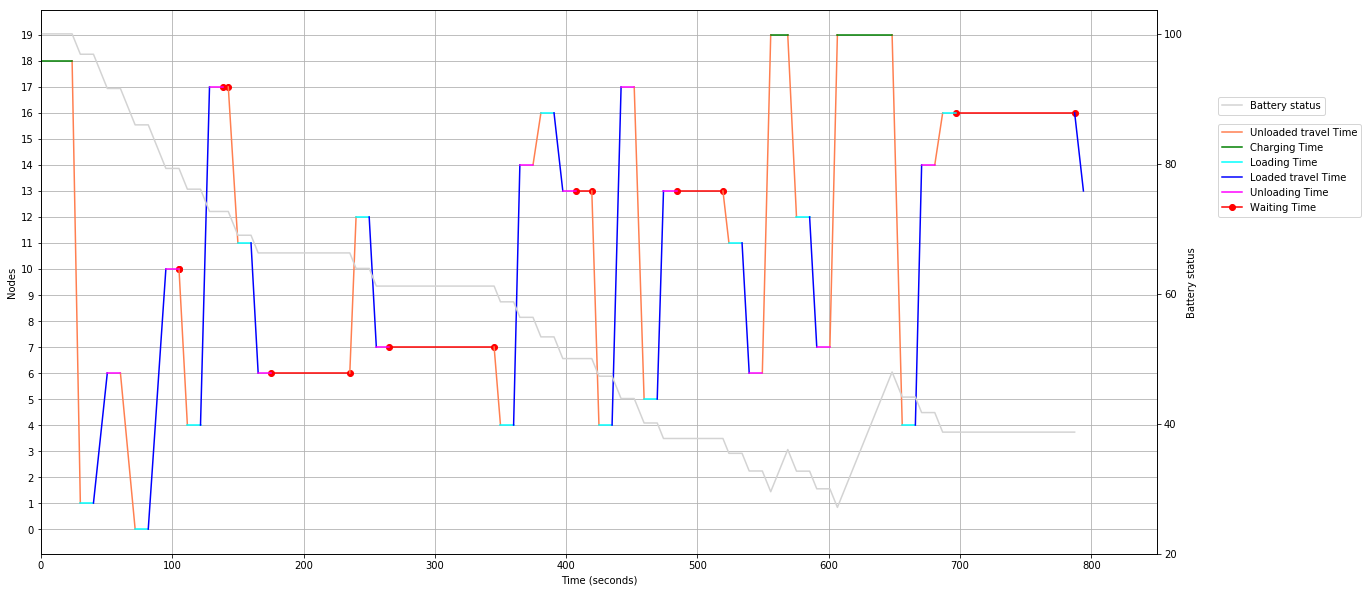

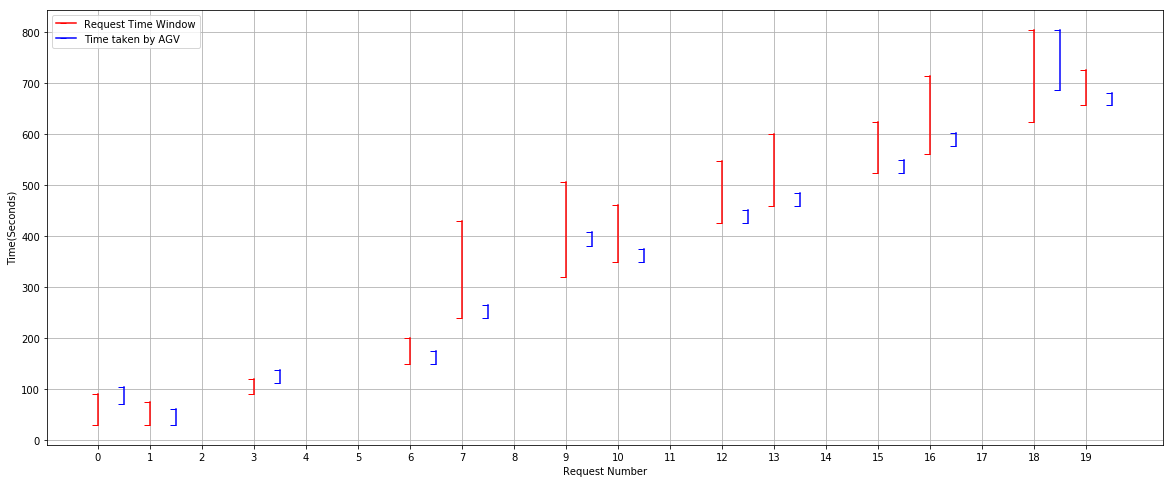

Optimize a model with 75 rows, 68 columns and 132 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+01, 1e+02]
  RHS range        [2e+00, 8e+02]
Presolve removed 75 rows and 68 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6205933e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  6.620593333e+02
The optimal objective is 662.059
Variables of s:17
Lateness:15.53 seconds
S_0,D_0,B_0:0.0,60.0,100.0
S_1,D_1,B_1:60.0,80.53333333333333,94.12631327666666
S_2,D_2,B_2:80.53333333333333,105.0,88.85964661
S_3,D_3,B_3:105.0,119.77,86.77097994333333
S_4,D_4,B_4:119.77,138.83599999999998,84.38597994333333
S_5,D_5,B_5:138.83599999999998,161.66543507999998,79.85297994333332
S_6,D_6,B_6:161.66543507999998,300.0,73.43826240333333
S_7,D_7,B_7:300.0,322.74076344,71.61621153033333
S_8,

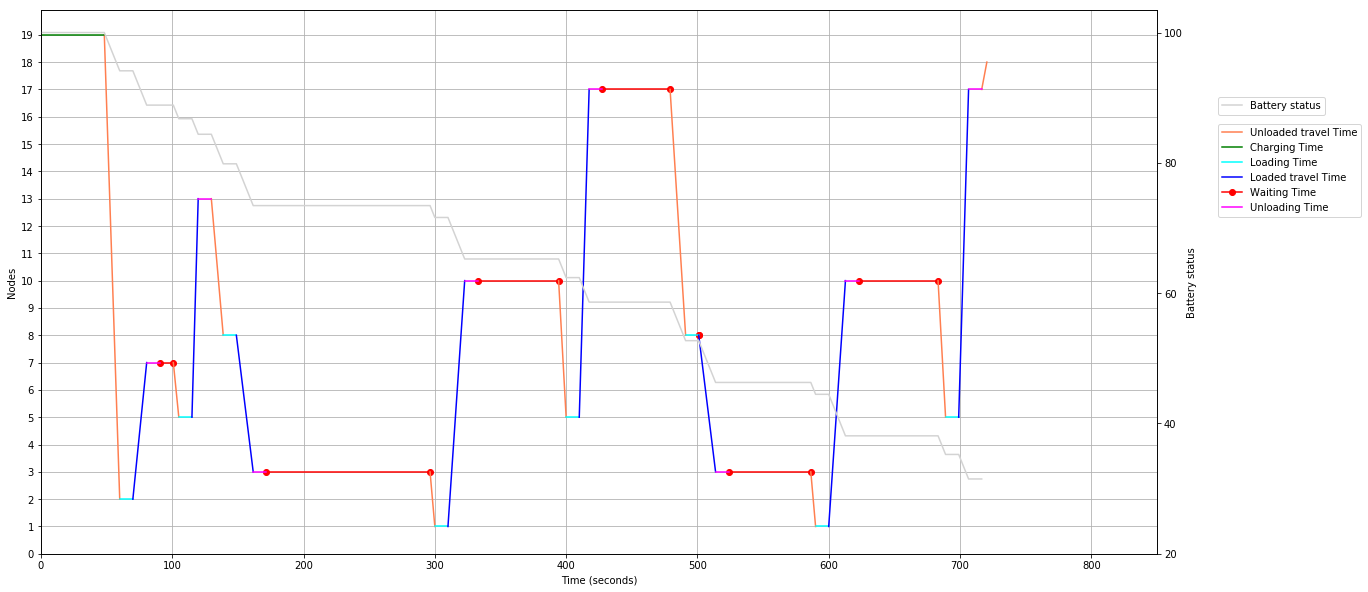

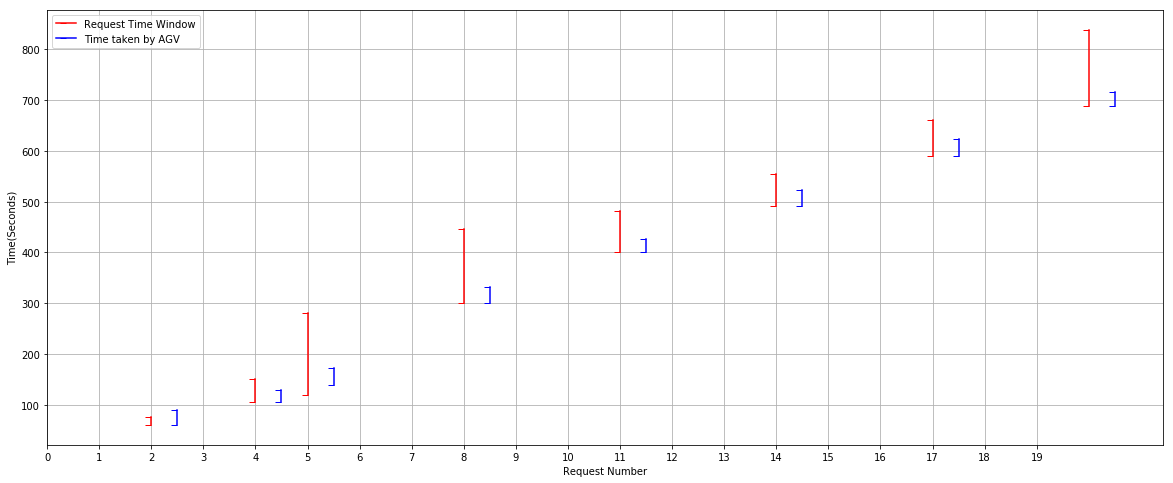

[[1], []]
TO#1: From 1 to 6, window: 30 - 75, capability: B
TO#0: From 0 to 10, window: 30 - 90, capability: A
TO#3: From 4 to 17, window: 90 - 120, capability: A
TO#6: From 11 to 6, window: 150 - 201, capability: A
TO#7: From 12 to 7, window: 240 - 430, capability: B
TO#10: From 4 to 14, window: 350 - 461, capability: B
TO#9: From 16 to 13, window: 320 - 506, capability: A
TO#12: From 4 to 17, window: 425 - 547, capability: A
TO#13: From 5 to 13, window: 458 - 600, capability: B
TO#15: From 11 to 6, window: 524 - 623, capability: A
Task Charge, type:C - From 6 to 19 window:0 - 0, Minimum Processing:0.9009003293333606 secs
TO#16: From 12 to 7, window: 561.284940442 - 714, capability: B
Task Charge, type:C - From 7 to 19 window:0 - 0, Minimum Processing:17.805413558666665 secs
TO#19: From 4 to 14, window: 656 - 726, capability: B
TO#18: From 16 to 13, window: 623 - 804, capability: A
---------------------after-----------------
TO#1: From 1 to 6, window: 30 - 75, capability: B
TO#0: From

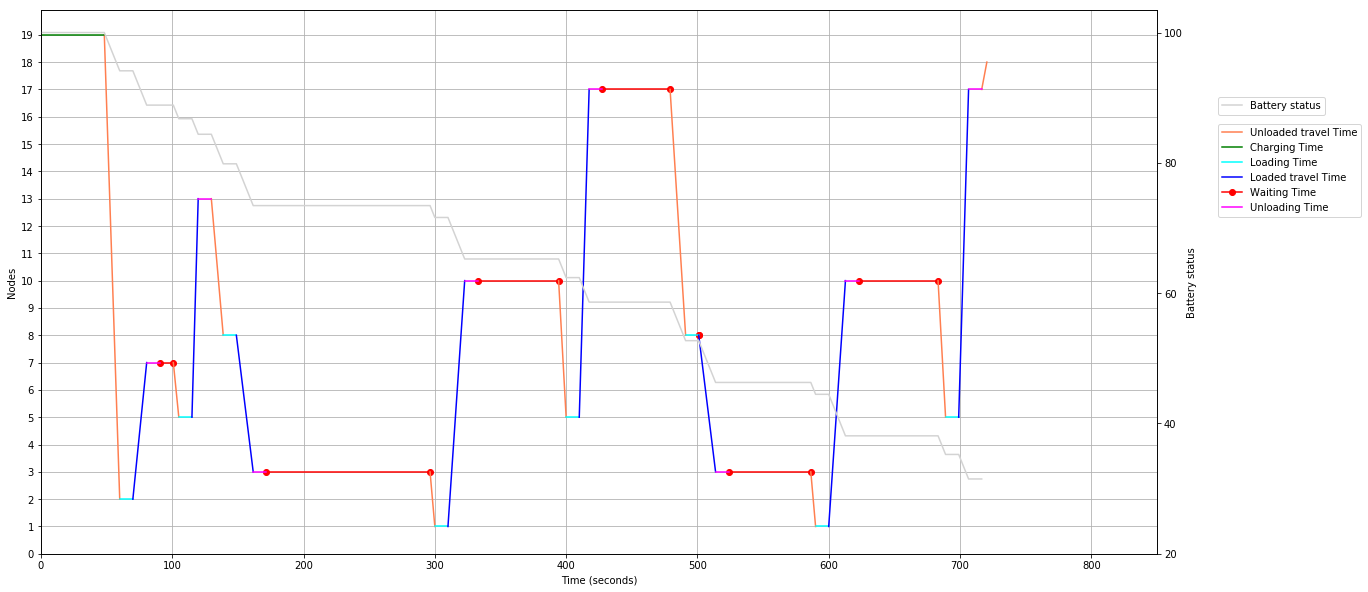

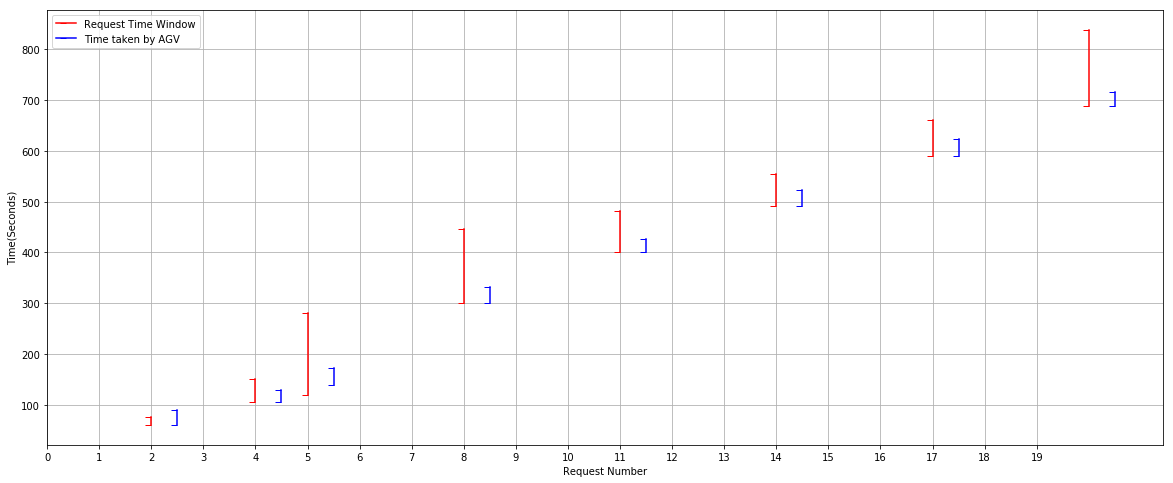

KeyError: 'Dr'

In [10]:
# read demand file and create Transport Orders and add to scheduler list
createRequests(r'demand.xlsx') #use r to avoid errors due to / etc...

#create stations by reading excel file
createStations(r'stations.xlsx')
#create AGV objects by reading from file
createAGVs(r'agvs.xlsx')

#create initial sequence for agvs based on current demand by using clarke saving algorithm
createSequenceTO()

#write sequence in a file after post processing
writeSequenceToFile()

#solve & improve LP
tardinessLP=[]
solve()

In [ ]:
#KPI from initial sequence
#Calculate total lateness
tardinessGreedy = sum(l.lateness for l in agvs)
#calculate total loaded and unloaded travel

### KPI

### ALNS --->

In [ ]:

'''
Destroy and Repair methods
'''
def destroyRandomCharge(agv):
    print(
    '''
    randomly remove a charging task from sequence of tasks of a random agv
    '''
    )
#     agv = np.random.choice(agvs)
    randomChargeTask = list(filter(lambda x:x.taskType=='C',agv.taskList))[0]
    if randomChargeTask:
        agv.taskList.remove(randomChargeTask)

def destroyAllCharge(agv):
    print(
    '''
    destroy all the charging tasks of a random agv
    '''
        )
#     agv = np.random.choice(agvs)
    chargeTasks = list(filter(lambda x:x.taskType=='C', agv.taskList))
    if chargeTasks:
        agv.taskList = [task for task in agv.taskList if task not in chargeTasks]
    
def destroyWorstCharge(agv):
    print(
    '''
    remove a charge task which leads to least increase in charge% from a random agv
    '''
        )
#     agv = np.random.choice(agvs)
    agvIndex = agvs.index(agv) # index of selected agv
    chargeTasks = list(filter(lambda x:x.taskType=='C', agv.taskList))
    
    if len(chargeTasks)==1:
        print("1")
        agv.taskList.remove(chargeTasks[0])
        return
    
    minCharge = 10000
    if chargeTasks:
        for i,ct in enumerate(chargeTasks):
            taskL = taskList[agvIndex] #grab schedule of selected agv
            ct1 = list(filter(lambda x:x['IDF']==ct.idf,taskL))[0]
            indexct1 = taskL.index(ct1) 
            if taskL[indexct1+1]:
                ct2 = taskL[indexct1+1]
                chargePC = ct2['WAIT']*agv.chargingRate #seconds * %/sec
            else:
                chargePC = 10000

            if chargePC<minCharge:
                minCharge = chargePC
                taskToRemove = ct1
        
        print("Destroyed:",ct1)
        agv.taskList.remove(taskToRemove)


def repairInsertNCCharge(agv):
    print(
    '''
    repair sequence by introducing a Non-Critical charge after tasks in a random agv
    '''
        )
#     agv = np.random.choice(agvs)
    initCharge = 100 #assummed to be 100 at the moment
    initNode = agv.startNode
    
    for t,task in enumerate(agv.taskList):
        estDist = getDistanceFromNode(initNode, task.source) + getDistanceFromNode(task.source,task.dest)
        estDrivingTime = estDist/agv.speed #seconds
        estCharge = initCharge-(estDrivingTime*agv.dischargeRate)
        if estCharge<60:
            if agv.taskList[t+1]:
                nextTask = agv.taskList[t+1]
                possibleCharge = nextTask.ept 
                dists = [getDistanceFromNode(task.dest,station.getNode()) for station in chargingStations]
                optIndex = dists.index(min(dists))
                nearestChargeNode = chargingStations[optIndex].getNode()
                ncTask = Task("Ncharge",0,task.dest,nearestChargeNode, 0, 0, 'NC', cap=0,index=99)
                agv.taskList.insert(t+1,ncTask)
                break
        else:
            initNode = task.dest
            initCharge = initCharge - estCharge
            
            
def repairInsertCCharge(agv):
    print(
    '''
    repair sequence by introducing a Critical charge after tasks in a random agv
    '''
        )
#     agv = np.random.choice(agvs)
    initCharge = 100 #assummed to be 100 at the moment
    initNode = agv.startNode
    
    for t,task in enumerate(agv.taskList):
        estDist = getDistanceFromNode(initNode, task.source) + getDistanceFromNode(task.source,task.dest)
        estDrivingTime = estDist/agv.speed #seconds
        estCharge = initCharge-(estDrivingTime*agv.dischargeRate)
        if estCharge<30:
            if agv.taskList[t+1]:
                nextTask = agv.taskList[t+1]
                possibleCharge = nextTask.ept 
                dists = [getDistanceFromNode(task.dest,station.getNode()) for station in chargingStations]
                optIndex = dists.index(min(dists))
                nearestChargeNode = chargingStations[optIndex].getNode()
                ncTask = Task("Charge",0,task.dest,nearestChargeNode, 0, 0, 'C', cap=0,index=99)
                agv.taskList.insert(t+1,ncTask)
                break
        else:
            initNode = task.dest
            initCharge = initCharge - estCharge
    
    pass

def repairInsertAllCharge(agv):
    print(
    '''
    repair sequence by introducing a charge task after every task in a random agv
    '''
        )
#     agv = np.random.choice(agvs)
    chargeTasks = list(filter(lambda x:x.taskType=='C', agv.taskList))
    if chargeTasks:
        agv.taskList = [task for task in agv.taskList if task not in chargeTasks]
        
        
        
    taskCopy = agv.taskList.copy()
    agv.taskList.clear()
    
    for t in taskCopy:
        agv.taskList.append(t)
        dists = [getDistanceFromNode(t.dest,station.getNode()) for station in chargingStations]
        optIndex = dists.index(min(dists))
        nearestChargeNode = chargingStations[optIndex].getNode()
        cTask = Task("Charge",0,t.dest,nearestChargeNode, 0, 0, 'C', cap=0,index=99)
        agv.taskList.append(cTask)
        
        
def calculate_score(task_List):
    '''
    Calculate score of a given schedule
    '''
    score = 0.0
    for tasklist in task_List.values():
        for task in tasklist:
            if task.get('IDF') and task['Request_Number'] !=99:
                tardScore = max(0,task['Dr']-task['LDT'])
                score = score + tardScore
            score = score+ task['UDIST']
    return score # smaller score indicates better performance

def updateWeightVectors(rhoD, rhoR):
    rhoD=[val/sum(rhoD) for val in rhoD]
    rhoR=[val/sum(rhoR) for val in rhoR]
    return rhoD, rhoR
    
def alns(numIter):
    '''
    take intial solution and improve it
    '''
   
    psi1 = 0.4 # if new solution is new global best
    psi2 = 0.3 # if new solution is accepted but not the best
    psi3 = 0.2 # if new solution is rejected
    
    lambdaP = 0.5 # lambda parameter to control update of weight vector
    
    bestSol = taskList.copy()
    bestScore = calculate_score(bestSol)
    '''
    Initialize set of destroy and repair methods, initialize weights of respective methods
    '''
    
    destroy = [destroyRandomCharge,destroyWorstCharge,destroyAllCharge] # destroy methods
    repair = [repairInsertCCharge,repairInsertNCCharge,repairInsertAllCharge] # repair methods
    rhoD=[1/len(destroy) for i in range(len(destroy))] # weight vector of destroy methods
    rhoR=[1/len(repair) for i in range(len(repair))] # weight vector of repair methods
    '''
    select a destroy and a repair method based on their respective weights
    '''
    for _ in range(numIter):

        #select random agv for doing destroy and repair
        agv = np.random.choice(agvs) 
        selD = np.random.choice(destroy,p=rhoD)
        indexD = destroy.index(selD) # index of destroy method
        selR = np.random.choice(repair,p=rhoR) 
        indexR = repair.index(selR) # index of repair method

        
        selD(agv) # destroy agv sequence
        selR(agv) # repair agv sequence
        
        writeSequenceToFile() # write the sequence to file, HERE THE SEQUENCE IS REWRITTEN FOR BOTH AGVs, 
        # BUT SUBSEQUENTLY SCHEDULING IS DONE FOR ONLY 1 AGV, scheduling should be done for all agvs
        
        isSolvable = solve() # LP produces feasible solution and returns true otherwise false
        
        if isSolvable:
            
            xt = taskList.copy()
            currentScore = calculate_score(xt)
            
            if currentScore < bestScore:
                bestSol = xt
                bestScore = currentScore
                rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi1
                rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi1
                rhoD,rhoR = updateWeightVectors(rhoD, rhoR)
                print("BEST",rhoD)
                print("BEST",rhoR)
            else:
                rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi2
                rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi2
                rhoD, rhoR = updateWeightVectors(rhoD, rhoR)
                print("SUB",rhoD)
                print("SUB",rhoR)
        else:
            rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi3
            rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi3
            rhoD, rhoR = updateWeightVectors(rhoD, rhoR)
            print(rhoD)
            print(rhoR)
            print('Solution was infeasible and hence unacceptable')
    print(f'rhoD:{rhoD}')
    print(f'rhoR:{rhoR}')
    return bestSol
    

In [ ]:
b=alns(5)

In [ ]:
b

In [ ]:
utravel = 0.0
ltravel = 0.0
for a in b.values():
    for r in a:
        utravel+=r['UDIST']
        ltravel+=r['LDIST']
print(f'Unloaded Travel Distance:{utravel}')
print(f'Loaded Travel Distance:{ltravel}')

In [ ]:
for tasklist in b.values():
        for task in tasklist:
            if task.get('IDF'):
                t = max(0,task['Dr']-task['LDT'])
print(t)

In [ ]:
for t in b.values():
    for t1 in t:
        if t1.get('IDF') and t1['Request_Number'] !=99:
            print(t1.get('IDF'),t1.get('Dr')-t1.get('LDT'))

In [26]:
import random

li =[1]
random.choice(li)


1